## Hindi NLP project

### The goal of this project is to practice the state-of-art NLP method on Hindi language

#### Intro
The NLP has been widely used and developed in English language, however it is not as developed in other languages as in English. A lot of the time it is simply becasue it takes too much time and data to develope a new text processing tool for each of its language varieties. 

Hindi is one of the most used languages in India. The difficulities of applying NLP tool to Hindi are: 
- Lack of available libraries
- Tokenization
- A lof of NLP processing methods based on English(stemming, lemmatization, TF-IDF, etc.) are not suitable
- Lack of data

To try to tackle the above issues, the SentencePiece tokenizer released by Google is a great option. It has some advantages like:
- Purely data driven: pre-tokenization is not always required. It can train on the raw sentences. 
- Language independent: Works for all the languages. 

To define SentencePiece: it is a re-implementation of sub-word units, an effective way to alleviate the open vocabulary problems in neural machine translation. 

More details about SentencePiece please go to: https://github.com/google/sentencepiece

#### Data
The data consists of 4335 Hindi documents with tags from the BBC Hindi News website. 
There are 14 unique categories. Each document has exactly one tag associated with it. These are the tags: india, pakistan, news, international, entertainment, sport, science, china, learningenglish, social, southasia, business, institutional, multimedia.

More details about the dataset please go to: https://github.com/NirantK/hindi2vec/releases/tag/bbc-hindi-v0.1

#### Result
Accuracy: 0.412240

#### Future Improvement 
This project by no means is a finished project, it can be improved in many aspects, namely:
- To train the SentencePiece on a larger Hindi corpus
- Creating validation set for cross-validation (did not do it becasue of lack of time)
- Try to fine-tune more about the model (very time consuming)
- Maybe try some traditional ML classifier other than RNN 
- Get Kappa to work


In [275]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud 
import re
from nltk.corpus import stopwords
import sentencepiece as spm
from fastai.text import *

import fastai, torch

In [211]:
path = ('/Users/GeorgeQiao/Desktop/hands_on_machine_learning_projects/BBC_NLP_Hindi')

In [27]:
df_train = pd.read_csv('hindi-train.csv', sep="\t", encoding='utf-8', header=None)
df_train.columns = ['tag', 'text']

In [28]:
df_train.head()

,tag,text
0,india,मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से...
1,pakistan,नेटिजन यानि इंटरनेट पर सक्रिय नागरिक अब ट्विटर...
2,news,इसमें एक फ़्लाइट एटेनडेंट की मदद की गुहार है औ...
3,india,"प्रतीक खुलेपन का, आज़ाद ख्याली का और भीड़ से अ..."
4,india,ख़ासकर पिछले 10 साल तक प्रधानमंत्री रहे मनमोहन...


In [30]:
df_train['text'][0]

'मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से नोएडा जाने का समय काफी कम हो जाएगा और यात्रियों को राजीव चौक या मंडी हाउस से होकर नहीं जाना पड़ेगा.लेकिन, यह मजेंटा लाइन इसलिए भी महत्वपूर्ण है क्योंकि इस पर ड्राइवलैस यानी बिना ड्राइवर वाली मेट्रो चलाने की योजना है. ऐसा भारत में पहली बार होगा जब कोई मेट्रो बिना ड्राइवर के चलाई जाएगी. मेट्रो के तीसरे फेज में भारत में पहली बार ड्राइवरलेस तकनीक आएगी लेकिन दुनिया भर में कई देशों में ड्राइवरलेस मेट्रो पहले से ही चलती हैं. इन देशों में ड्राइवरलेस मेट्रो सफल भी रही हैं. दक्षिण कोरिया की राजधानी सोल में ड्राइवलेस ट्रेन कामयाबी से चल रही है. ये मेट्रो ज़मीन के नीचे चलती है इसमें ड्राइवर का केबिन भी नहीं होता है. यूरोप में डेनमार्क, स्पेन, इटली, फ्रांस, जर्मनी, हंगरी, स्विट्जरलैंड और ब्रिटेन में भी ड्राइवरलैस मेट्रो चलती है. इन देशों में एक से ज़्यादा शहरों में भी ऐसी मेट्रो चलाई जाती है. इनके अलावा अमेरिका और कनाडा में भी ड्राइवरलेस ट्रेन चलती है. वहीं, ब्राजील, पेरू और चाइल में भी इस तरह की मेट्रो काफ़ी पहले आ चुकी है. भारत के पड़ोसी देश चीन में

In [29]:
df_test = pd.read_csv('hindi-test.csv', sep="\t", encoding='utf-8', header=None)
df_test.columns = ['tag', 'text']

In [26]:
df_test.head()

,tag,text
0,india,बुधवार को राज्य सभा में विपक्ष के सवालों के जव...
1,india,लखनऊ स्थित पत्रकार समीरात्मज मिश्र को बुलंदशहर...
2,india,लगभग 1300 हेक्टेयर ज़मीन का अधिग्रहण किया जा च...
3,international,हालांकि उनके अंगरक्षकों को बमों को जाम करने वा...
4,india,आयोग का कहना है कि इस तरह के परीक्षण से महिलाओ...


In [17]:
with open('bbc-hindi-news.json') as f:
    data = json.load(f)
    for p in data[:1]:
        print('heading: ' + p['heading'])
        print('intro: ' + p['intro'])
        print('tag: ' + p['tag'])
        print('url: ' + p['url'])
        print('content: ' + p['body'])

heading: नई सड़क ने डाला हाशिए पर
intro: रामस्वरुप साव चालीस साल तक रा़ष्ट्रीय राजमार्ग क्रमांक दो पर एक दुकान के मालिक थे. वे अपने जीवन से संतुष्ट थे.
tag: india
url: http://www.bbc.com/hindi/india/2010/03/100328_highway_uprooted_vv.shtml
content: फिर एक दिन घोषणा हुई कि पुराने जीटी रोड को अब चौड़ा करके फ़ोर लेन बनाया जाएगा. बिना कुछ समझे और लोगों की तरह वे भी ख़ुश हुए.लेकिन सड़क का निर्माण शुरु हुआ तो रामस्वरूप साव सड़क पर दुकान के मालिक से एकाएक पीछे एक दुकान के किराएदार हो गए.सड़क बनने के बाद अब उनकी कमाई आधी रह गई है. वे सब्ज़ियाँ बेचा करते थे.हज़ारीबाग ज़िले के चौपारण चौराहे पर सड़क के दोनों ओर बसा एक गाँव है. जो शिकायत रामस्वरूप साव की है वही यहाँ के 42 दुकानदारों की है.विष्णु प्रसाद साव भी सब्ज़ी बेचते हैं. वे बताते हैं कि जब सड़क का निर्माण शुरु हुआ तो अधिकारियों ने उन्हें आश्वासन दिया था कि दुकाने तोड़ी जा रही हैं लेकिन बाद में एक नया बाज़ार बना दिया जाएगा.दूसरे दुकानदार का भी आरोप है कि प्रशासन ने उन्हें कुछ कागज़ भी दिए थे लेकिन कुछ किया नहीं.हाइवे हिंदुस्तान की टीम के पास 

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3468 entries, 0 to 3467
Data columns (total 2 columns):
tag     3468 non-null object
text    3467 non-null object
dtypes: object(2)
memory usage: 54.3+ KB


In [39]:
df_train.isnull().sum()

tag     0
text    1
dtype: int64

In [40]:
df_train = df_train.dropna()

In [41]:
df_train.isnull().sum()

tag     0
text    0
dtype: int64

In [33]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 2 columns):
tag     867 non-null object
text    866 non-null object
dtypes: object(2)
memory usage: 13.6+ KB


In [42]:
df_test.isnull().sum()

tag     0
text    1
dtype: int64

In [43]:
df_test = df_test.dropna()

In [44]:
df_test.isnull().sum()

tag     0
text    0
dtype: int64

In [45]:
df_train['tag'].value_counts()

india              1389
international       904
entertainment       285
sport               258
news                230
science             194
business             54
pakistan             43
southasia            42
institutional        19
social               18
china                14
multimedia           12
learningenglish       5
Name: tag, dtype: int64

In [46]:
df_train['tag'].value_counts(normalize=True) * 100

india              40.063455
international      26.074416
entertainment       8.220363
sport               7.441592
news                6.633978
science             5.595616
business            1.557543
pakistan            1.240265
southasia           1.211422
institutional       0.548024
social              0.519181
china               0.403807
multimedia          0.346121
learningenglish     0.144217
Name: tag, dtype: float64

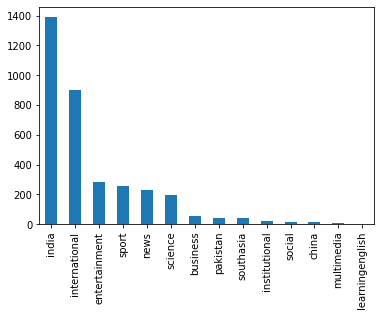

In [47]:
df_train["tag"].value_counts().plot(kind='bar')
plt.show()

- we can see that the data is highly imblanced, accuracy might not be a good indicator, the kappa can be used when we interpret the result.

In [62]:
# build dictionary with key=category and values as all the descriptions related.
cat_desc = dict()
for cat in list(df_train['tag']): 
    text = " ".join(df_train.loc[df_train['tag']==cat, 'text'].values)
    cat_desc[cat] = text

In [138]:
stopword_hindi=open("stopwords_hindi.txt",'r')
stop_words_hindi=[]
# pre-process stopword
for i in stopword_hindi:
    i = re.sub('[\n]', '', i)
    stop_words_hindi.append(i)
    stopwords_hindi = set(stop_words_hindi)

#combine hindi stopwords and english stopwords together
stopwords_hindi_english = stopwords_hindi.union(set(stopwords.words('english')))

In [139]:
len(stopwords_hindi_english)

348

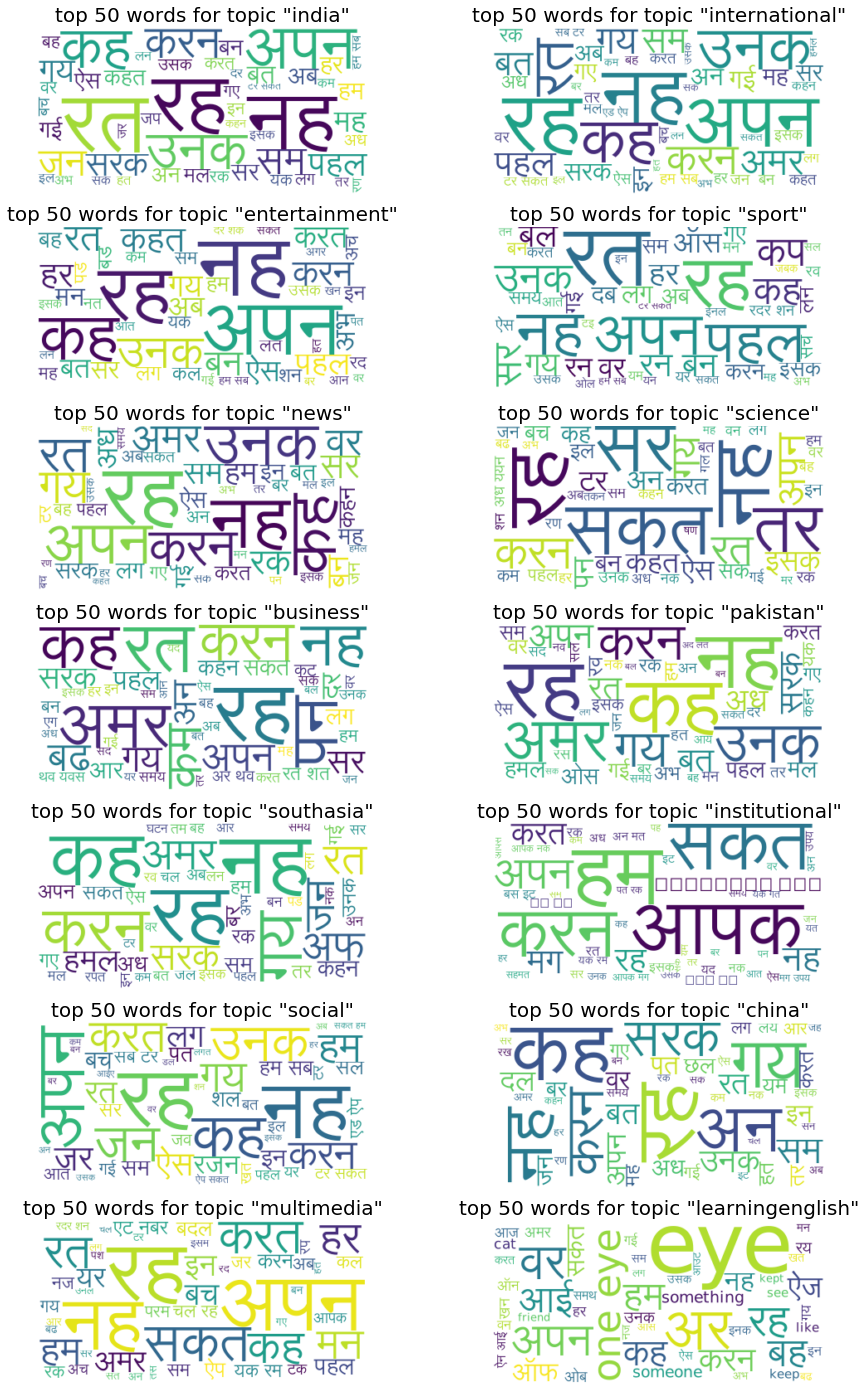

In [143]:
#creating word cloud pictures
wordcloud_india = WordCloud(font_path='Lohit-Devanagari-chandas1-2.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['india'])
wordcloud_international = WordCloud(font_path='Lohit-Devanagari-chandas1-2.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['international'])
wordcloud_entertainment = WordCloud(font_path='Lohit-Devanagari-chandas1-2.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['entertainment'])
wordcloud_sport = WordCloud(font_path='Lohit-Devanagari-chandas1-2.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['sport'])
wordcloud_news = WordCloud(font_path='Lohit-Devanagari-chandas1-2.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['news'])
wordcloud_science = WordCloud(font_path='Lohit-Devanagari-chandas1-2.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['science'])
wordcloud_business = WordCloud(font_path='Lohit-Devanagari-chandas1-2.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['business'])
wordcloud_pakistan = WordCloud(font_path='Lohit-Devanagari-chandas1-2.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['pakistan'])
wordcloud_southasia = WordCloud(font_path='Lohit-Devanagari-chandas1-2.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['southasia'])
wordcloud_institutional = WordCloud(font_path='Lohit-Devanagari.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['institutional'])
wordcloud_social = WordCloud(font_path='Lohit-Devanagari-chandas1-2.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['social'])
wordcloud_china = WordCloud(font_path='Lohit-Devanagari-chandas1-2.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['china'])
wordcloud_multimedia = WordCloud(font_path='Lohit-Devanagari-chandas1-2.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['multimedia'])
wordcloud_learningenglish = WordCloud(font_path='Lohit-Devanagari-chandas1-2.ttf', stopwords = stopwords_hindi_english, max_font_size=100, max_words=50, background_color="white").generate(cat_desc['learningenglish'])


fig = plt.figure(figsize=(15,25))

fig.add_subplot(7,2,1)
plt.title("top 50 words for topic \"india\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_india, interpolation="bilinear")

fig.add_subplot(7,2,2)
plt.title("top 50 words for topic \"international\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_international, interpolation="bilinear")

fig.add_subplot(7,2,3)
plt.title("top 50 words for topic \"entertainment\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_entertainment, interpolation="bilinear")

fig.add_subplot(7,2,4)
plt.title("top 50 words for topic \"sport\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_sport, interpolation="bilinear")

fig.add_subplot(7,2,5)
plt.title("top 50 words for topic \"news\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_news, interpolation="bilinear")

fig.add_subplot(7,2,6)
plt.title("top 50 words for topic \"science\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_science, interpolation="bilinear")

fig.add_subplot(7,2,7)
plt.title("top 50 words for topic \"business\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_business, interpolation="bilinear")

fig.add_subplot(7,2,8)
plt.title("top 50 words for topic \"pakistan\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_pakistan, interpolation="bilinear")

fig.add_subplot(7,2,9)
plt.title("top 50 words for topic \"southasia\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_southasia, interpolation="bilinear")

fig.add_subplot(7,2,10)
plt.title("top 50 words for topic \"institutional\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_institutional, interpolation="bilinear")

fig.add_subplot(7,2,11)
plt.title("top 50 words for topic \"social\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_social, interpolation="bilinear")

fig.add_subplot(7,2,12)
plt.title("top 50 words for topic \"china\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_china, interpolation="bilinear")

fig.add_subplot(7,2,13)
plt.title("top 50 words for topic \"multimedia\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_multimedia, interpolation="bilinear")

fig.add_subplot(7,2,14)
plt.title("top 50 words for topic \"learningenglish\"",fontsize=20)
plt.axis("off")
plt.imshow(wordcloud_learningenglish, interpolation="bilinear")

plt.show()



In [162]:
#combaine all the text together for the sentencepiece to train
# spm_train = ''
# for i in df_train['text']:
#     spm_train = spm_train + i + '\n'   

In [164]:
len(spm_train)

8660846

In [184]:
#combaine all the text together for the sentencepiece to train
with open('spm_train.txt', 'w',encoding='utf-8') as f:
    for i in df_train['text']:
        f.write(i + '\n')
f.close()

In [258]:
# Train the sentencepiece Model
print("Training model...")
spm.SentencePieceTrainer.Train('--input=spm_train.txt  --model_prefix=hindi_train --vocab_size=16000 --character_coverage=0.9995')

Training model...


True

In [190]:
sp = spm.SentencePieceProcessor()
sp.Load("hindi_train.model")

True

In [191]:
#test case for the text on row 1 in the df_train
sp.EncodeAsPieces(df_train['text'][0])

['▁मेट्रो',
 '▁की',
 '▁इस',
 '▁लाइन',
 '▁के',
 '▁चलने',
 '▁से',
 '▁दक्षिणी',
 '▁दिल्ली',
 '▁से',
 '▁नो',
 'एड',
 'ा',
 '▁जाने',
 '▁का',
 '▁समय',
 '▁काफी',
 '▁कम',
 '▁हो',
 '▁जाएगा',
 '▁और',
 '▁यात्र',
 'ियों',
 '▁को',
 '▁राजी',
 'व',
 '▁चौक',
 '▁या',
 '▁मंडी',
 '▁हाउस',
 '▁से',
 '▁हो',
 'कर',
 '▁नहीं',
 '▁जाना',
 '▁पड़ेगा',
 '.',
 'लेकिन',
 ',',
 '▁यह',
 '▁म',
 'जेंट',
 'ा',
 '▁लाइन',
 '▁इस',
 'लिए',
 '▁भी',
 '▁महत्व',
 'पूर्ण',
 '▁है',
 '▁क्यों',
 'कि',
 '▁इस',
 '▁पर',
 '▁ड्राइव',
 'ल',
 'ैस',
 '▁यान',
 'ी',
 '▁बिना',
 '▁ड्राइवर',
 '▁वाली',
 '▁मेट्रो',
 '▁चलाने',
 '▁की',
 '▁योजना',
 '▁है',
 '.',
 '▁ऐस',
 'ा',
 '▁भारत',
 '▁में',
 '▁पहली',
 '▁बार',
 '▁होगा',
 '▁जब',
 '▁कोई',
 '▁मेट्रो',
 '▁बिना',
 '▁ड्राइवर',
 '▁के',
 '▁चलाई',
 '▁जाएगी',
 '.',
 '▁मेट्रो',
 '▁के',
 '▁तीसरे',
 '▁फे',
 'ज',
 '▁में',
 '▁भारत',
 '▁में',
 '▁पहली',
 '▁बार',
 '▁ड्राइवर',
 'लेस',
 '▁तकनीक',
 '▁आएगी',
 '▁लेकिन',
 '▁दुनिया',
 '▁भर',
 '▁में',
 '▁कई',
 '▁देश',
 'ों',
 '▁में',
 '▁ड्राइवर',
 'लेस',
 '▁मेट्रो',
 '▁पहले

In [198]:
# test for encode
# encode: text => id
print(sp.encode_as_pieces('नई सड़क ने डाला हाशिए पर'))
print(sp.encode_as_ids('नई सड़क ने डाला हाशिए पर'))

['▁नई', '▁सड़क', '▁ने', '▁डाला', '▁हाशि', 'ए', '▁पर']
[571, 716, 14, 1755, 6170, 267, 13]


In [199]:
# test for decode
# decode: id => text
print(sp.decode_pieces(['▁नई', '▁सड़क', '▁ने', '▁डाला', '▁हाशि', 'ए', '▁पर']))
print(sp.decode_ids([571, 716, 14, 1755, 6170, 267, 13]))

नई सड़क ने डाला हाशिए पर
नई सड़क ने डाला हाशिए पर


In [200]:
# returns vocab size
print(sp.get_piece_size())

16000


In [214]:
# save all the decoded vocab to hindi_vocab
sp = spm.SentencePieceProcessor()
sp.Load('/Users/GeorgeQiao/Desktop/hands_on_machine_learning_projects/BBC_NLP_Hindi/hindi_train.model')
itos = [sp.IdToPiece(int(i)) for i in range(16000)]
hindi_vocab = Vocab(itos)

In [218]:
itos[:10]

['<unk>', '<s>', '</s>', '.', '▁के', '▁में', '▁है', '▁की', '▁और', '▁हैं']

In [203]:
#tokenization for the train and test dataset
# def encode_text(texts):
#     sp = spm.SentencePieceProcessor()
#     sp.Load('hindi_train.model')
#     encodedtext = []
#     for text in texts:
#         encodedtext.append(sp.encode_as_ids(text))
#     return encodedtext

# train_encoded = encode_text(df_train.text)
# test_encoded = encode_text(df_test.text)

In [213]:
#creating tokenization clas
class HindiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str('/Users/GeorgeQiao/Desktop/hands_on_machine_learning_projects/BBC_NLP_Hindi/hindi_train.model'))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [221]:
# creating tokenizer object for the future classifier 
tokenizer = Tokenizer(tok_func=HindiTokenizer, lang='hi')

In [264]:
# creating the text classifier
data_clas = TextClasDataBunch.from_df(path=path, train_df=df_train, valid_df=df_test, tokenizer=tokenizer, vocab=hindi_vocab)

In [265]:
data_clas.save('itos.pkl')

In [266]:
# tokenized(decoded) data
data_clas.show_batch()

text,target
▁ <unk> o <unk> ▁19 20 ▁के ▁दशक ▁में ▁फ़ ीफ़ा ▁के ▁अध्यक्ष ▁जू ल्स ▁रि मे ▁और ▁फ़्रांस ▁के ▁फ़ ुटबॉल ▁प्रशास कों ▁ने ▁दुनिया ▁की ▁बेहतरी न ▁फ़ ुटबॉल ▁टीम ▁तय ▁करने ▁के ▁लिए ▁प्रतियोगिता ▁कर ाने ▁का ▁विचार ▁किया . ▁19 29 ▁में ▁फ़ ीफ़ा ▁ने ▁एक ▁प्रस्ताव ▁पारित ▁करके ▁विश्व ▁कप ▁फ़ ुटबॉल ▁आयोज ित ▁कर ाने ▁का ▁फ़ैसला ▁किया .19 30 ▁में ▁शुरू ▁हुई ▁ये,sport
"▁ <unk> o <unk> ▁खिलाड़ियों ▁ने ▁रंग ीन ▁पो शाक ें ▁पहनन ी ▁शुरू ▁की , ▁गेंद ▁उज ली ▁हो ▁गई ▁और ▁अंपायर ▁तक ▁रंग ीन ▁पो शाक ▁में ▁नज़र ▁आने ▁लगे . ▁मैच ▁दिन - रात ▁के ▁होने ▁लगे ▁और ▁50- 50 ▁ओवर ों ▁के ▁मैच ▁होने ▁लगे . पहले ▁तीन ▁विश्व ▁कप ▁इंग्लै ंड ▁में ▁आयोज ित ▁हुए ▁और ▁तीन ▁में ▁दो ▁विश्व ▁कप ▁का ▁ख़िताब ▁वेस्टइंडीज ़",sport
▁ <unk> o <unk> ▁1 . ▁यात्रा ▁का ▁आनंद ः ▁दत्ता त्र े य ▁बाल कृष्ण ▁' का का ' ▁काले ल कर का का ▁काले ल कर ▁शुरू ▁में ▁गुजराती ▁में ▁लिखते ▁थे . ▁उनकी ▁' हिम ालय ▁यात्रा ' ▁अनु द ित ▁हो कर ▁हिंदी ▁में ▁छपी ▁थी . ▁बाद ▁में ▁वो ▁हिंदी ▁में ▁ही ▁लिख ने ▁लगे . उन्हें ▁यात्रा ओं ▁में ▁बहुत ▁आनंद ▁आता ▁था .,india
"▁ <unk> o <unk> ▁‘ आँखों ▁का ▁था ▁क़सूर , ▁छु री ▁दिल ▁पे ▁चल ▁गई ▁आँखों ▁ही ▁आँखों ▁में ▁इशार ा ▁हो ▁गया ▁आँखों ▁से ▁बड़ी ▁कोई ▁त राज़ ू ▁नहीं ▁होती ▁ अंखिय ों ▁के ▁झ रो ख ों ▁से ▁ <unk> e <unk> ▁5 ▁ . ▁वग़ैरह आप ▁सोच ▁रहे ▁होंगे ▁कि ▁आज ▁हम ▁ये ▁कैसी ▁बातें ▁कर ▁रहें . ▁क्या ▁करें ▁मौसम ▁ही ▁कुछ ▁ऐस ा",learningenglish
"▁ <unk> o <unk> ▁30 ▁जनवरी ▁19 48 ▁को ▁शाम ▁पाँच ▁बज कर ▁प ंद्र ह ▁मिनट ▁पर ▁जब ▁गाँधी ▁लग भग ▁भाग ते ▁हुए ▁बिर ला ▁हाउस ▁के ▁प्रार्थना ▁स्थल ▁की ▁तरफ़ ▁बढ़ ▁रहे ▁थे , ▁तो ▁उनके ▁स्टाफ ़ ▁के ▁एक ▁सदस्य ▁गुर बच न ▁सिंह ▁ने ▁अपनी ▁घड़ ी ▁की ▁तरफ़ ▁देखत े ▁हुए ▁कहा ▁था , ▁"" बाप ू ▁आज ▁आपको ▁थोड़ी ▁देर ▁हो ▁गई .""",india


In [267]:
data_clas.sanity_check()

In [272]:
# creating a learner object for the text classification, with AWD_LSTM (long short-term memory networks) learning method
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)

In [280]:
learn.freeze()

In [281]:
#fine-tuning the learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


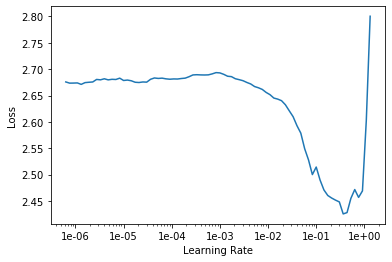

In [282]:
learn.recorder.plot()

In [284]:
learn.loss_func.func

CrossEntropyLoss()

In [283]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.067884,1.755570,0.412240,23:51


In [285]:
kappa = KappaScore()
learn.metrics = [kappa, accuracy]

In [290]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,1.649067,586.519653,-0.000561,0.001155,1:57:43
1,1.636378,1.703355,0.000646,0.412240,1:49:15


In [287]:
learn.save('first-full')

In [ ]:
learn.save('final')

In [291]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [45, 400]            0          False     
______________________________________________________________________
RNNDropout           [45, 1152]           0          False     
______________________________________________________________________
RNNDropout           [45, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________